In [89]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [90]:
df = pd.read_pickle(r"../base_processed.pkl")

In [91]:
data = []
for i in range(1, 14):
    a = df[df['age_category'] == i]
    if len(a) >= 1000:
        data.append(a.sample(1000, random_state=13)) 

data_more_than_thousand = pd.concat(data)

In [92]:
res = pl.from_pandas(data_more_than_thousand).group_by("age_category").agg(
    total_people = pl.col("cancelled_trial").count(),
    cancelled_trial = pl.col("cancelled_trial").sum(),
    fraction_cancelled = pl.col("cancelled_trial").mean(),
    cancelled_trial_flg = pl.col("cancelled_trial"),
    std = pl.col("cancelled_trial").std(),
    se = pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5),
    ci_95p = (pl.col("cancelled_trial").std()/(pl.col("cancelled_trial").count()**0.5))*1.96
).to_pandas()
res = res.sort_values(by="age_category").reset_index(drop=True)
res

,age_category,total_people,cancelled_trial,fraction_cancelled,cancelled_trial_flg,std,se,ci_95p
0,2,1000,597,0.597,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, ...",0.490746,0.015519,0.030417
1,3,1000,507,0.507,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...",0.500201,0.015818,0.031003
2,4,1000,526,0.526,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.499573,0.015798,0.030964
3,5,1000,445,0.445,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",0.497214,0.015723,0.030818
4,6,1000,416,0.416,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.493140,0.015594,0.030565
5,7,1000,396,0.396,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.489309,0.015473,0.030328
6,8,1000,354,0.354,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, ...",0.478448,0.015130,0.029655


In [93]:
res_new = res.explode("cancelled_trial_flg")
res_new.cancelled_trial_flg = pd.to_numeric(res.explode("cancelled_trial_flg").cancelled_trial_flg)
res_new.head(5)

,age_category,total_people,cancelled_trial,fraction_cancelled,cancelled_trial_flg,std,se,ci_95p
0,2,1000,597,0.597,1,0.490746,0.015519,0.030417
0,2,1000,597,0.597,0,0.490746,0.015519,0.030417
0,2,1000,597,0.597,1,0.490746,0.015519,0.030417
0,2,1000,597,0.597,0,0.490746,0.015519,0.030417
0,2,1000,597,0.597,1,0.490746,0.015519,0.030417


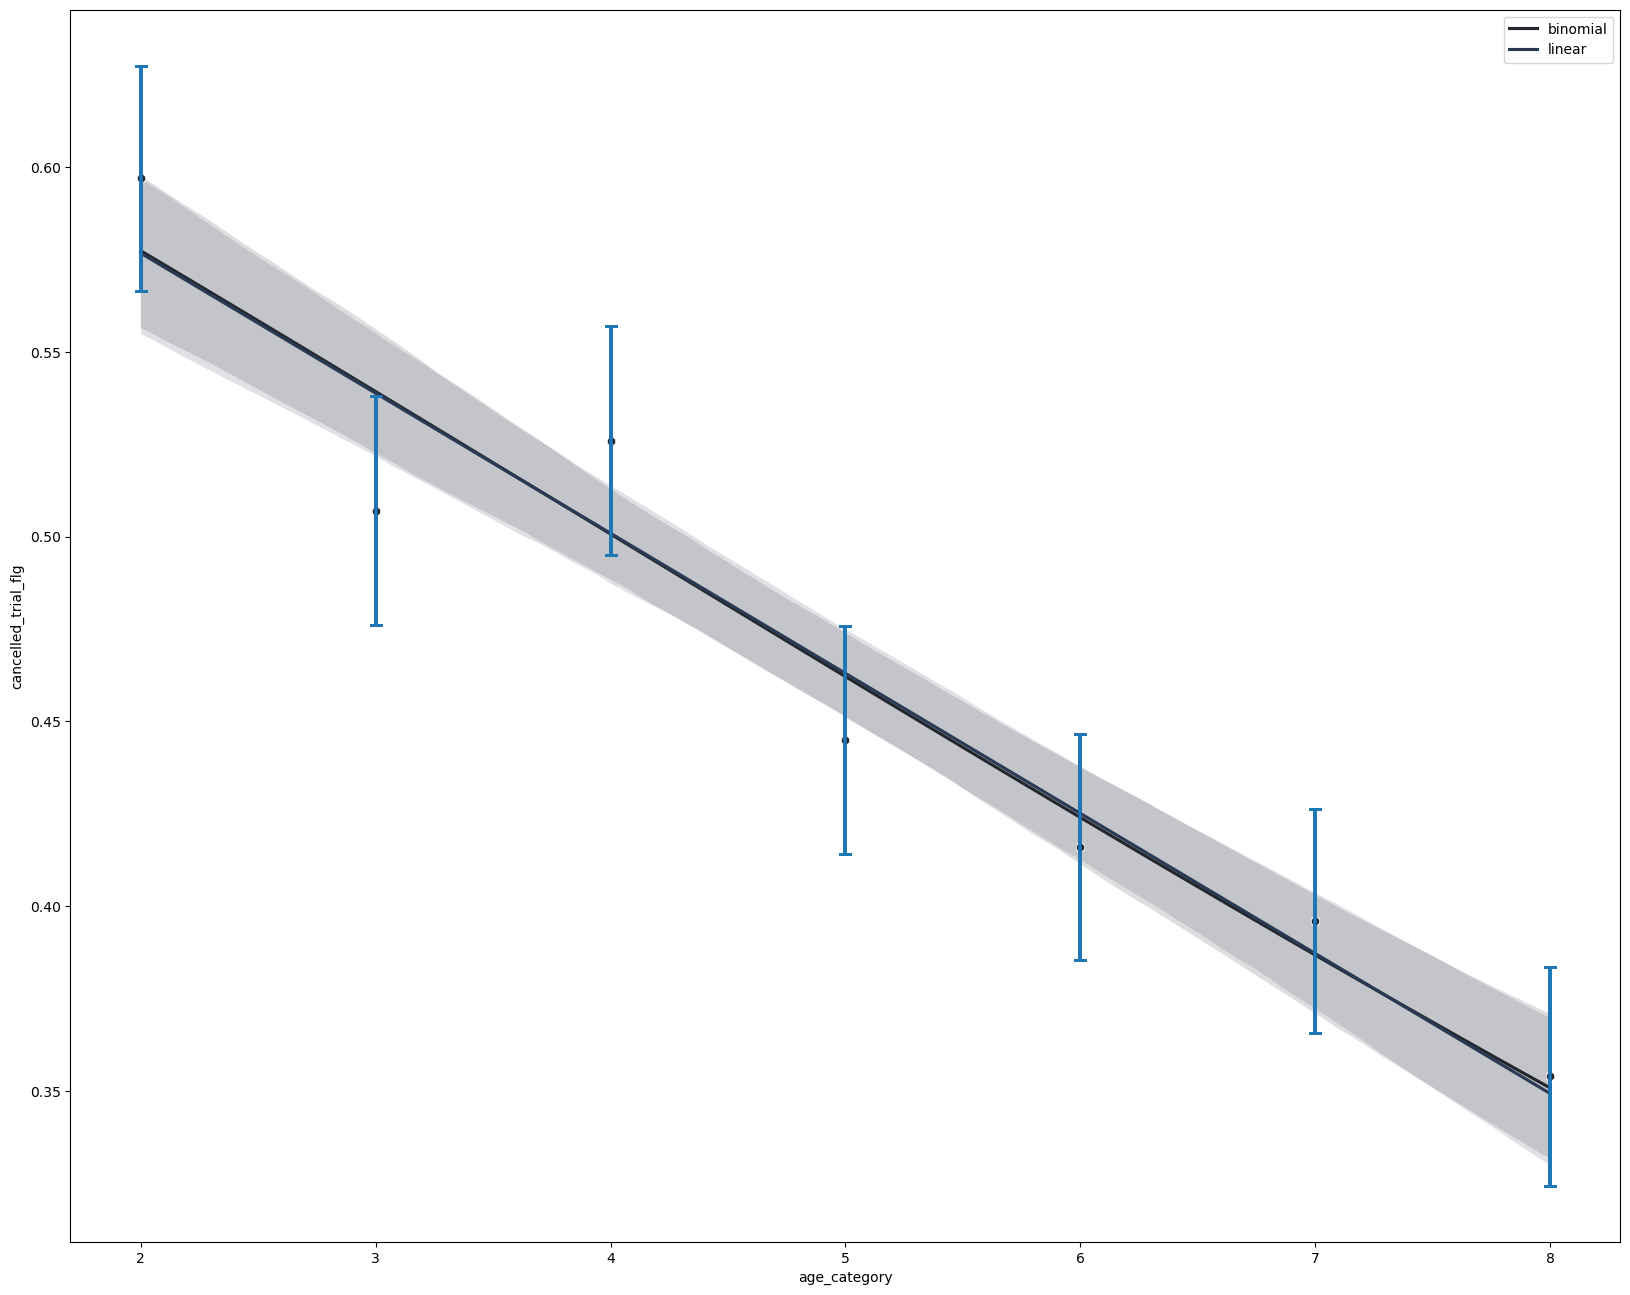

In [103]:
with sns.color_palette("dark:#428bf9"):
    fig, ax = plt.subplots(figsize = (20,16))
    sns.regplot(data=res_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, logistic=True, label="binomial")
    sns.regplot(data=res_new, x = "age_category", y = "cancelled_trial_flg",scatter=False, label='linear')
    sns.scatterplot(data=res_new, x = "age_category", y = "fraction_cancelled")
    # sns.scatterplot(data=res_new[res_new["cancelled_trial_flg"]==1], x = "age_category", y = "cancelled_trial_flg", size="cancelled_trial", legend = False)
    # sns.scatterplot(data=res_new[res_new["cancelled_trial_flg"]==0], x = "age_category", y = "cancelled_trial_flg", size=(res_new[res_new["cancelled_trial_flg"]==0]["total_people"] - res_new[res_new["cancelled_trial_flg"]==0]["cancelled_trial"]), legend=False)
    plt.errorbar(data=res_new, x = "age_category", y = "fraction_cancelled", yerr="ci_95p", fmt="none", capsize=4)
    # fig.savefig("../images/regplot.png"

In [95]:
X = res_new.age_category #to_numpy()
Y = res_new.cancelled_trial_flg.to_numpy()
X = sm.add_constant(X)

lin_model = sm.OLS(Y,X)
bin_model = sm.GLM(Y, X, family=sm.families.Binomial())
lin_res = lin_model.fit()
bin_res = bin_model.fit()

print(lin_res.summary(), bin_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     165.5
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.91e-37
Time:                        13:20:02   Log-Likelihood:                -4979.5
No. Observations:                7000   AIC:                             9963.
Df Residuals:                    6998   BIC:                             9977.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6525      0.016     41.131   